In [ ]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=785434845bee8abb1fa833e89b610f88f1995963ff8f591a78f2987e5de629e3
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.manifold import trustworthiness
from sklearn.decomposition import PCA
from minisom import MiniSom
from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn.manifold import trustworthiness, MDS
from sklearn.cluster import KMeans
import random

np.random.seed(1234556)

data = load_wine()
X = StandardScaler().fit_transform(data.data)
y = data.target
n_points, dim_low = X.shape[0], 2

In [ ]:
def evaluate_som_on_wine_data(grid_size=7, pca_components=5, som_iterations=10000, random_state=42):
    # Apply PCA
    pca = PCA(n_components=pca_components)
    X_pca = pca.fit_transform(X)

    # Initialize SOM
    som = MiniSom(grid_size, grid_size, pca_components, sigma=3.0, learning_rate=0.5, random_seed=random_state)
    som.train_random(X_pca, som_iterations)

    # Compute BMUs
    bmu_indices = [som.winner(x) for x in X_pca]

    # Node majority class
    node_samples = [[[] for _ in range(grid_size)] for _ in range(grid_size)]
    for i, bmu in enumerate(bmu_indices):
        node_samples[bmu[0]][bmu[1]].append(y[i])

    node_majority = np.full((grid_size, grid_size), -1, dtype=int)
    for i in range(grid_size):
        for j in range(grid_size):
            if node_samples[i][j]:
                counter = Counter(node_samples[i][j])
                node_majority[i, j] = counter.most_common(1)[0][0]

    cmap = ListedColormap(['red', 'green', 'blue'])

    # Visualization 1: SOM Grid
    plt.figure(figsize=(10, 10))
    node_majority_masked = np.ma.masked_where(node_majority == -1, node_majority)
    plt.imshow(node_majority_masked, cmap=cmap, vmin=0, vmax=2)
    for i, (x, y_) in enumerate(zip(X_pca, y)):
        bmu = bmu_indices[i]
        offset = (np.random.rand(2) - 0.5) * 0.4
        plt.plot(bmu[0] + 0.5 + offset[0], bmu[1] + 0.5 + offset[1], 'o', color=cmap(y_), markersize=5)
    plt.colorbar(ticks=[0, 1, 2], label='Majority Cultivar')
    plt.title('SOM with PCA for Wine Dataset')
    plt.show()

    # Visualization 2: U-Matrix
    u_matrix = np.zeros((grid_size, grid_size))
    weights = som.get_weights()
    for i in range(grid_size):
        for j in range(grid_size):
            weight = weights[i, j]
            neighbors = []
            for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < grid_size and 0 <= nj < grid_size:
                    neighbors.append(weights[ni, nj])
            if neighbors:
                distances = [np.linalg.norm(weight - neighbor) for neighbor in neighbors]
                u_matrix[i, j] = np.mean(distances)

    plt.figure(figsize=(8, 6))
    plt.imshow(u_matrix, cmap='viridis')
    plt.colorbar(label='Average Distance to Neighbors')
    plt.title('U-Matrix for SOM')
    plt.xlabel('SOM Grid X Coordinate')
    plt.ylabel('SOM Grid Y Coordinate')
    plt.show()

    # Visualization 3: SOM Scatter
    plt.figure(figsize=(8, 6))
    for i, (x, y_) in enumerate(zip(X_pca, y)):
        bmu = bmu_indices[i]
        offset = (np.random.rand(2) - 0.5) * 0.4
        plt.scatter(bmu[0] + 0.5 + offset[0], bmu[1] + 0.5 + offset[1], c=cmap(y_), s=50, alpha=0.8)
    plt.xlabel('SOM Grid X Coordinate')
    plt.ylabel('SOM Grid Y Coordinate')
    plt.title('Scatter Plot of SOM+PCA Clustering for Wine Dataset')
    plt.grid(True)
    plt.show()

    # Visualization 4: PCA 2D Scatter
    pca_scatter = PCA(n_components=2)
    X_pca_scatter = pca_scatter.fit_transform(X)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca_scatter[:, 0], X_pca_scatter[:, 1], c=y, cmap=cmap, s=50, alpha=0.8)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA Scatter Plot for Wine Dataset')
    plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1', 'Class 2'], title="Classes")
    plt.grid(True)
    plt.show()

    # Silhouette Score
    cluster_labels = [bmu[0] * grid_size + bmu[1] for bmu in bmu_indices]
    sil_score = silhouette_score(X_pca, cluster_labels)
    print(f"Silhouette Score: {sil_score:.4f}")

    # Trustworthiness
    mds = MDS(n_components=2, random_state=random_state)
    X_mds = mds.fit_transform(X_pca)
    trust_score = trustworthiness(X_pca, X_mds)
    print(f"Trustworthiness: {trust_score:.4f}")

In [ ]:
def run_aco(num_iterations, num_ants, evaporation_rate):
    K_attract, K_repulse = 30, 50
    nbrs = NearestNeighbors(n_neighbors=K_attract + 1).fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)
    nbrs_repulse = NearestNeighbors(n_neighbors=K_repulse + 1).fit(X)
    indices_repulse = nbrs_repulse.kneighbors(X, return_distance=False)

    Y = np.random.randn(n_points, dim_low)
    pheromone = np.ones((n_points, dim_low))
    repulsion_strength, attraction_strength = 0.1, 0.5
    alpha = 0.5
    centering_interval = 20

    for iteration in range(num_iterations):
        move_scale = 0.1 * (1 - iteration / num_iterations)
        new_positions = []

        for _ in range(num_ants):
            ant_Y = Y.copy()
            for i in range(n_points):
                neighbors = indices[i][1:]
                attraction = sum(
                    ((ant_Y[j] - ant_Y[i]) /
                     (np.linalg.norm(ant_Y[j] - ant_Y[i]) + 1e-6)) * attraction_strength
                    for j in neighbors
                )
                neighbors_rep = indices_repulse[i][1:]
                repulsion = sum(
                    ((ant_Y[i] - ant_Y[j]) /
                     (np.linalg.norm(ant_Y[i] - ant_Y[j]) + 1e-6) ** 2) * repulsion_strength
                    for j in neighbors_rep if j != i
                )
                ant_Y[i] += move_scale * (attraction + repulsion) + alpha * pheromone[i] + np.random.randn(dim_low) * 0.01
            new_positions.append(ant_Y)

        costs = [np.var(pos) for pos in new_positions]
        Y = new_positions[np.argmax(costs)]
        pheromone = (1 - evaporation_rate) * pheromone + (new_positions[np.argmax(costs)] - Y) * 0.1

        if (iteration + 1) % centering_interval == 0:
            Y -= Y.mean(axis=0)
            scale = np.linalg.norm(Y, axis=1).max()
            if scale > 0:
                Y = Y / scale * 10

    Y = (Y - Y.mean(axis=0)) * 1.5
    sil_score = silhouette_score(Y, y)
    trust = trustworthiness(X, Y, n_neighbors=5)
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Trustworthiness: {trust:.4f}")

    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        plt.scatter(Y[y == label, 0], Y[y == label, 1], label=f'Class {label}')
    plt.legend()
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('ACO Dimension Reduction')
    plt.tight_layout()
    plt.show()



In [ ]:
def pso_select(pop_size=90, max_iter=90, n_clusters=3,
               alpha=0.5, w=0.8, c1=1.2, c2=1.2, k_trust=10):
    global X, y
    sigmoid = lambda z: 1 / (1 + np.exp(-z))
    bin_pos = lambda z: (sigmoid(z) > .5).astype(int)

    def trust(Xh, Xl, k=k_trust):
        n = Xh.shape[0]
        hi = NearestNeighbors(n_neighbors=n-1).fit(Xh).kneighbors(return_distance=False)
        lo = NearestNeighbors(n_neighbors=k).fit(Xl).kneighbors(return_distance=False)
        t = 0
        for i in range(n):
            ranks = np.array([np.where(hi[i] == j)[0][0] for j in lo[i]])
            t += np.sum((ranks > k-1) * (ranks - (k-1)))
        return 1 - (2 / (n*k*(2*n - 3*k - 1))) * t

    def fit_val(p):
        m = bin_pos(p)
        if m.sum() != 2: return np.inf
        Xs = X[:, m == 1]
        try:
            sil = silhouette_score(Xs, KMeans(n_clusters, n_init=1, random_state=42).fit_predict(Xs))
        except: return np.inf
        return -alpha*sil - (1-alpha)*trust(X, Xs)

    class Part:
        def __init__(self, d):
            while True:
                self.pos = np.random.uniform(-4,4,d)
                self.vel = np.zeros(d)
                self.best = self.pos.copy()
                self.best_fit = fit_val(self.pos)
                if self.best_fit != np.inf: break

    d = X.shape[1]
    swarm = [Part(d) for _ in range(pop_size)]
    gbest = min(swarm, key=lambda p:p.best_fit).best.copy()
    gbest_fit = fit_val(gbest)
    hist = []

    for _ in range(max_iter):
        for p in swarm:
            r1, r2 = random.random(), random.random()
            p.vel = w*p.vel + c1*r1*(p.best - p.pos) + c2*r2*(gbest - p.pos)
            p.pos += p.vel
            f = fit_val(p.pos)
            if f < p.best_fit:
                p.best_fit, p.best = f, p.pos.copy()
            if f < gbest_fit:
                gbest_fit, gbest = f, p.pos.copy()
        hist.append(gbest_fit)

    mask = bin_pos(gbest)
    Xs = X[:, mask == 1]
    labs = KMeans(n_clusters, random_state=42).fit_predict(Xs)
    sil = silhouette_score(Xs, labs)
    trust_val = trust(X, Xs)

    plt.figure(figsize=(8,6))
    scat = plt.scatter(Xs[:,0], Xs[:,1], c=y, cmap='tab10', edgecolor='k', s=60, alpha=.8)
    centres = KMeans(n_clusters, random_state=42).fit(Xs).cluster_centers_
    plt.scatter(centres[:,0], centres[:,1], marker='X', s=120)
    plt.title(f'Silhouette: {sil:.2f} | Trust: {trust_val:.2f}')
    plt.xlabel('Feature 1'); plt.ylabel('Feature 2'); plt.grid(True)
    plt.legend(*scat.legend_elements(), title='Class')
    plt.show()

    return mask, gbest_fit, hist

In [ ]:
def BAT_ALGORITHM(
    X,
    y=None,
    n_components=2,
    n_bats=40,
    max_iter=100,
    f_min=0.0,
    f_max=2.0,
    alpha=0.9,
    gamma=0.9,
    A0=1.0,
    r0=0.5,
    n_neighbors=10,
    n_clusters=3,
    return_embed=False):

    n_samples, n_features = X.shape
    dim = n_features * n_components

    pos   = np.random.uniform(-1, 1, (n_bats, dim))
    vel   = np.zeros_like(pos)
    loud  = np.full(n_bats, A0)
    pulse = np.full(n_bats, r0)

    def _proj(p):
        return X @ p.reshape(n_features, n_components)

    def _fit(p):
        return 1.0 - trustworthiness(X, _proj(p), n_neighbors=n_neighbors)

    fit  = np.apply_along_axis(_fit, 1, pos)
    best = pos[fit.argmin()].copy()
    best_fit = fit.min()

    for _ in range(max_iter):
        freq = f_min + (f_max - f_min) * np.random.rand(n_bats)
        vel  += (pos - best) * freq[:, None]
        cand  = pos + vel

        rand_mask = np.random.rand(*pos.shape) < pulse[:, None]
        cand      = np.where(rand_mask, cand, pos)

        fit_cand = np.apply_along_axis(_fit, 1, cand)
        better   = fit_cand < fit
        accept   = better & (np.random.rand(n_bats) < loud)

        pos[accept], fit[accept] = cand[accept], fit_cand[accept]

        idx = fit.argmin()
        if fit[idx] < best_fit:
            best, best_fit = pos[idx].copy(), fit[idx]

        loud  *= alpha
        pulse  = pulse * (1 - np.exp(-gamma))

    Z = _proj(best)
    labels = y if y is not None else KMeans(n_clusters).fit_predict(Z)

    sil   = silhouette_score(Z, labels)
    trust = 1.0 - best_fit

    print(f"Silhouette Score : {sil:.4f}")
    print(f"Trustworthiness  : {trust:.4f}")

    plt.figure(figsize=(6, 6))
    plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=20, cmap='viridis')
    plt.title("BAT Algorithm – 2-D embedding")
    plt.tight_layout()
    plt.show()

    return Z if return_embed else None

Silhouette Score: 0.5311
Trustworthiness: 0.8511


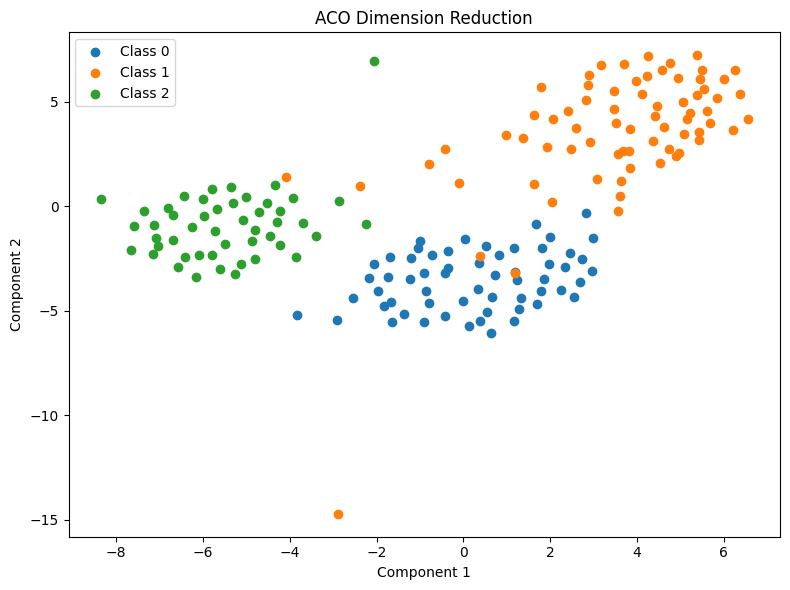

In [ ]:
run_aco(num_iterations=40, num_ants=20, evaporation_rate=0.2)

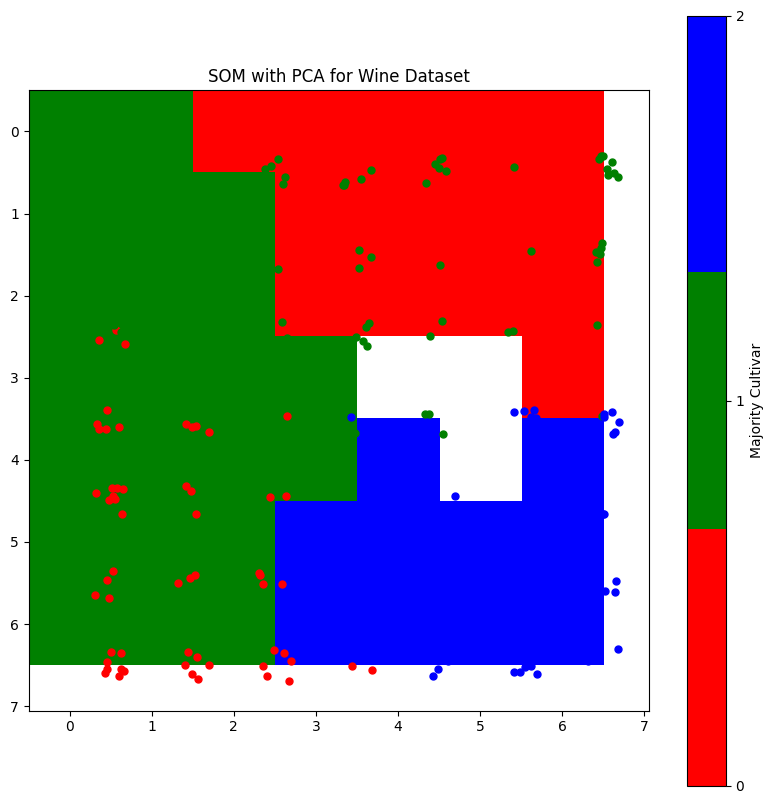

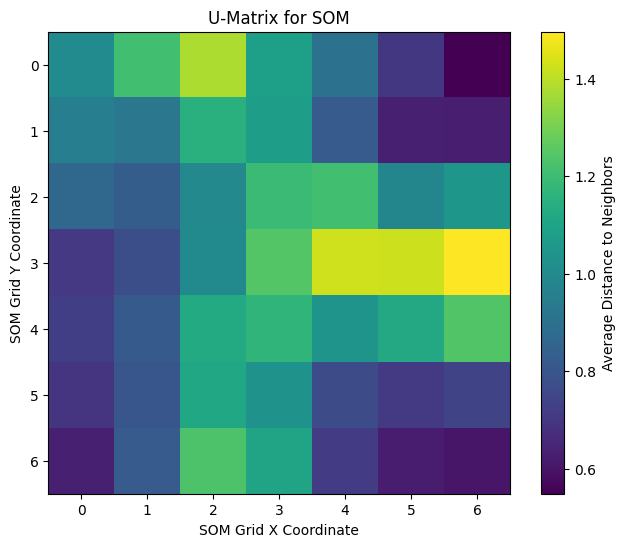

<ipython-input-11-3cc865be1b82>:67: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(bmu[0] + 0.5 + offset[0], bmu[1] + 0.5 + offset[1], c=cmap(y_), s=50, alpha=0.8)


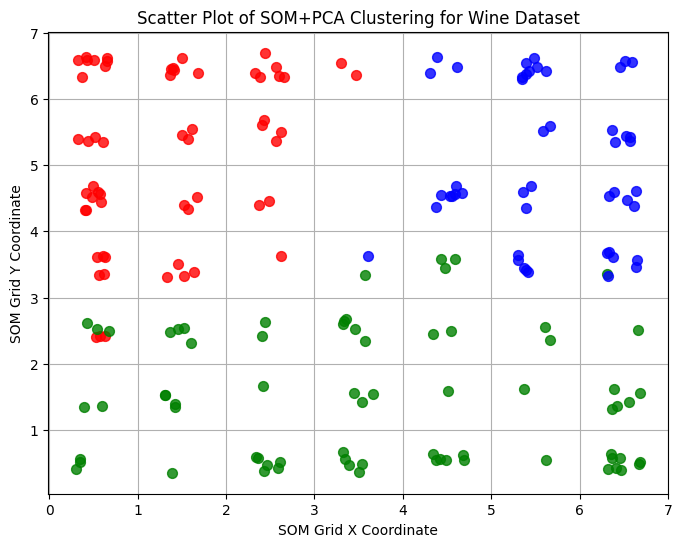

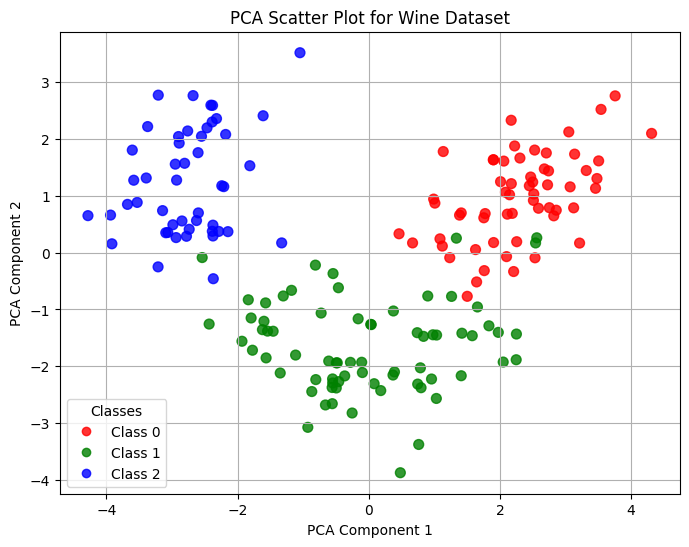

Silhouette Score: 0.0202
Trustworthiness: 0.9080


In [ ]:
evaluate_som_on_wine_data(grid_size=7, pca_components=5, som_iterations=10000, random_state=42)

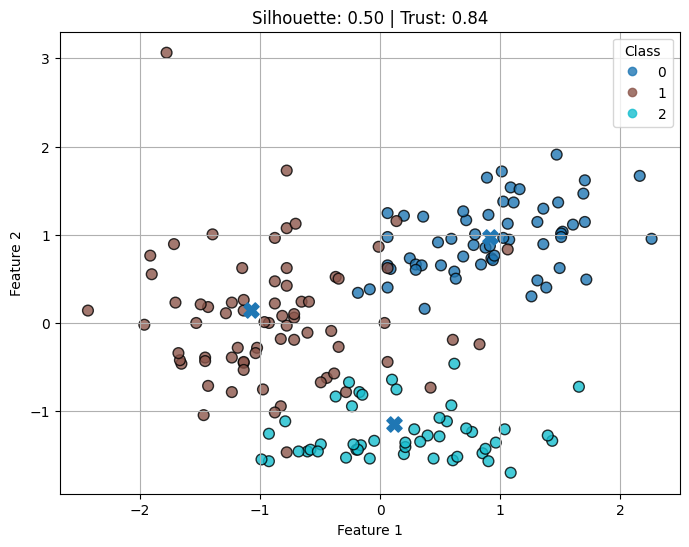

In [ ]:
mask, score, hist = pso_select(pop_size=90, max_iter=90,n_clusters=3, alpha=0.5,w=0.8, c1=1.2, c2=1.2, k_trust=10)

Silhouette Score : 0.3204
Trustworthiness  : 0.8622


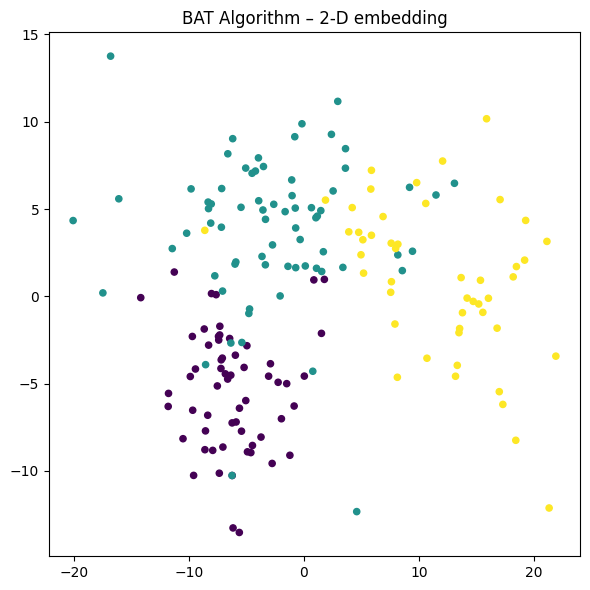

In [ ]:
BAT_ALGORITHM(X, y,n_components=2,n_bats=60,max_iter=120,f_min=0.0, f_max=2.0,alpha=0.90,gamma=0.80,A0=1.0, r0=0.5,n_neighbors=10,n_clusters=3,return_embed=False)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.manifold import trustworthiness

def run_abc(X, y, num_iterations=40, colony_size=20, limit=10):
    n_points, dim_original = X.shape
    dim_low = 2  # Target dimension

    # Nearest neighbors for attractive and repulsive forces
    K_attract, K_repulse = 30, 50
    nbrs = NearestNeighbors(n_neighbors=K_attract + 1).fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)
    nbrs_repulse = NearestNeighbors(n_neighbors=K_repulse + 1).fit(X)
    indices_repulse = nbrs_repulse.kneighbors(X, return_distance=False)

    # Initialize bee population (solutions)
    colony = [np.random.randn(n_points, dim_low) for _ in range(colony_size)]
    trial_counters = np.zeros(colony_size)
    repulsion_strength, attraction_strength = 0.1, 0.5

    def evaluate_fitness(pos):
        # Use variance as a pseudo-objective (you can modify to use other measures)
        return np.var(pos)

    # Main ABC loop
    for iteration in range(num_iterations):
        for i in range(colony_size):
            current = colony[i].copy()
            k = np.random.randint(colony_size)
            while k == i:
                k = np.random.randint(colony_size)

            phi = np.random.uniform(-1, 1, (n_points, dim_low))
            new_pos = current + phi * (current - colony[k])

            # Neighborhood attraction & repulsion
            for idx in range(n_points):
                neighbors = indices[idx][1:]
                attraction = sum(
                    ((new_pos[j] - new_pos[idx]) /
                     (np.linalg.norm(new_pos[j] - new_pos[idx]) + 1e-6)) * attraction_strength
                    for j in neighbors
                )
                neighbors_rep = indices_repulse[idx][1:]
                repulsion = sum(
                    ((new_pos[idx] - new_pos[j]) /
                     (np.linalg.norm(new_pos[idx] - new_pos[j]) + 1e-6) ** 2) * repulsion_strength
                    for j in neighbors_rep if j != idx
                )
                new_pos[idx] += 0.05 * (attraction + repulsion)

            if evaluate_fitness(new_pos) > evaluate_fitness(current):
                colony[i] = new_pos
                trial_counters[i] = 0
            else:
                trial_counters[i] += 1

        # Scout bee phase: replace stagnating bees
        for i in range(colony_size):
            if trial_counters[i] > limit:
                colony[i] = np.random.randn(n_points, dim_low)
                trial_counters[i] = 0

    # Select the best solution
    fitnesses = [evaluate_fitness(pos) for pos in colony]
    best_Y = colony[np.argmax(fitnesses)]

    # Post-processing scaling
    best_Y = (best_Y - best_Y.mean(axis=0)) * 1.5

    # Metrics
    sil_score = silhouette_score(best_Y, y)
    trust = trustworthiness(X, best_Y, n_neighbors=5)
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Trustworthiness: {trust:.4f}")

    # Visualization
    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        plt.scatter(best_Y[y == label, 0], best_Y[y == label, 1], label=f'Class {label}')
    plt.legend()
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('ABC Dimension Reduction')
    plt.tight_layout()
    plt.show()

Silhouette Score: -0.2970
Trustworthiness: 0.5338


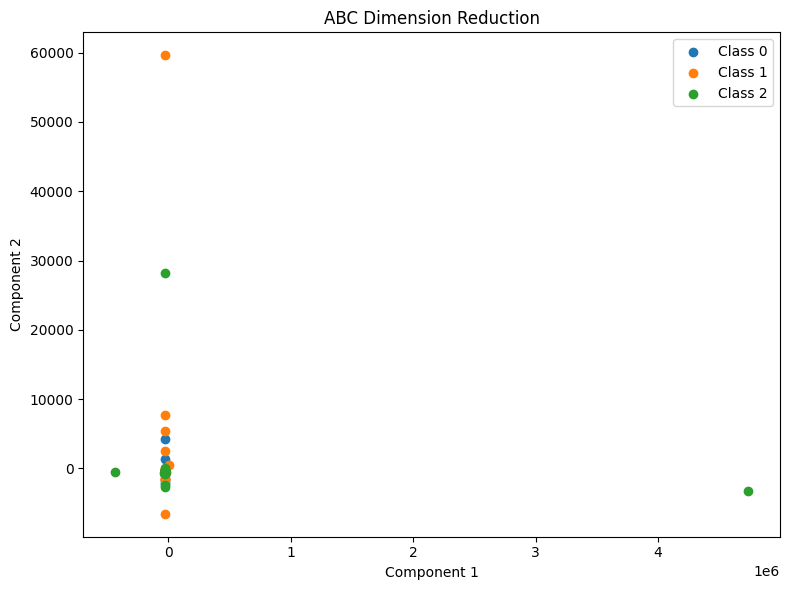

In [ ]:
run_abc(X, y, num_iterations=40, colony_size=20, limit=10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, trustworthiness

def run_abc_enhanced(num_iterations=100, num_bees=20, limit=5):
    # Parameters
    K_attract = 30
    n_points, dim_high = X.shape
    dim_low = 2

    # Nearest neighbors in high-dimensional space for local attraction guidance
    nbrs = NearestNeighbors(n_neighbors=K_attract + 1).fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)

    # Initialize bees randomly
    bee_positions = [np.random.randn(n_points, dim_low) for _ in range(num_bees)]
    trial_counters = np.zeros(num_bees)

    # Evaluate fitness combining global variance & local trustworthiness
    def evaluate_fitness(pos):
        var_score = np.var(pos)
        trust_score = trustworthiness(X, pos, n_neighbors=5)
        return var_score * 0.7 + trust_score * 0.3

    # Initial fitness
    fitnesses = [evaluate_fitness(pos) for pos in bee_positions]

    for iteration in range(num_iterations):
        dynamic_scale = 0.1 * (1 - iteration / num_iterations)

        # Employed bee phase
        for i in range(num_bees):
            candidate = bee_positions[i].copy()
            phi = np.random.uniform(-1, 1, (n_points, dim_low))
            k = np.random.choice([j for j in range(num_bees) if j != i])
            candidate += phi * (bee_positions[i] - bee_positions[k])

            # Local neighborhood guidance
            for j in range(n_points):
                neighbors = indices[j][1:]
                attraction = sum(
                    ((candidate[n] - candidate[j]) /
                     (np.linalg.norm(candidate[n] - candidate[j]) + 1e-6)) * 0.5
                    for n in neighbors
                )
                candidate[j] += 0.05 * attraction

            # Evaluate candidate
            fit_candidate = evaluate_fitness(candidate)
            if fit_candidate > fitnesses[i]:
                bee_positions[i] = candidate
                fitnesses[i] = fit_candidate
                trial_counters[i] = 0
            else:
                trial_counters[i] += 1

        # Onlooker bee phase
        prob = np.array(fitnesses) / np.sum(fitnesses)
        for _ in range(num_bees):
            i = np.random.choice(num_bees, p=prob)
            candidate = bee_positions[i].copy()
            phi = np.random.uniform(-1, 1, (n_points, dim_low))
            k = np.random.choice([j for j in range(num_bees) if j != i])
            candidate += phi * (bee_positions[i] - bee_positions[k])

            # Neighborhood refinement
            for j in range(n_points):
                neighbors = indices[j][1:]
                attraction = sum(
                    ((candidate[n] - candidate[j]) /
                     (np.linalg.norm(candidate[n] - candidate[j]) + 1e-6)) * 0.5
                    for n in neighbors
                )
                candidate[j] += 0.05 * attraction

            fit_candidate = evaluate_fitness(candidate)
            if fit_candidate > fitnesses[i]:
                bee_positions[i] = candidate
                fitnesses[i] = fit_candidate
                trial_counters[i] = 0
            else:
                trial_counters[i] += 1

        # Scout bee phase (adaptive abandonment)
        abandonment_threshold = int(num_bees * (0.2 + 0.3 * (iteration / num_iterations)))
        worst_indices = np.argsort(fitnesses)[:abandonment_threshold]
        for i in worst_indices:
            bee_positions[i] = np.random.randn(n_points, dim_low)
            fitnesses[i] = evaluate_fitness(bee_positions[i])
            trial_counters[i] = 0

    # Best solution post-processing
    best_index = np.argmax(fitnesses)
    best_Y = bee_positions[best_index]
    best_Y -= best_Y.mean(axis=0)
    scale = np.linalg.norm(best_Y, axis=1).max()
    if scale > 0:
        best_Y = best_Y / scale * 10

    # Evaluation
    sil_score = silhouette_score(best_Y, y)
    trust = trustworthiness(X, best_Y, n_neighbors=5)
    print(f"Silhouette Score (Enhanced ABC): {sil_score:.4f}")
    print(f"Trustworthiness (Enhanced ABC): {trust:.4f}")

    # Plotting
    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        plt.scatter(best_Y[y == label, 0], best_Y[y == label, 1], label=f'Class {label}')
    plt.legend()
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Enhanced ABC Dimension Reduction')
    plt.tight_layout()
    plt.show()

# Example usage:
run_abc_enhanced(num_iterations=100, num_bees=30, limit=10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.manifold import trustworthiness

def run_firefly(X, y, num_iterations=40, num_fireflies=20, beta0=1.0, gamma=1.0, alpha=0.2):
    n_points, dim_original = X.shape
    dim_low = 2  # Target dimension

    # Nearest neighbors for attractive and repulsive forces
    K_attract, K_repulse = 30, 50
    nbrs = NearestNeighbors(n_neighbors=K_attract + 1).fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)
    nbrs_repulse = NearestNeighbors(n_neighbors=K_repulse + 1).fit(X)
    indices_repulse = nbrs_repulse.kneighbors(X, return_distance=False)

    # Initialize fireflies (solutions)
    fireflies = [np.random.randn(n_points, dim_low) for _ in range(num_fireflies)]
    repulsion_strength, attraction_strength = 0.1, 0.5

    def evaluate_fitness(pos):
        return np.var(pos)  # You can replace with more sophisticated objectives

    # Main Firefly Algorithm loop
    for iteration in range(num_iterations):
        for i in range(num_fireflies):
            for j in range(num_fireflies):
                if evaluate_fitness(fireflies[j]) > evaluate_fitness(fireflies[i]):
                    rij = np.linalg.norm(fireflies[i] - fireflies[j])
                    beta = beta0 * np.exp(-gamma * rij ** 2)
                    move = beta * (fireflies[j] - fireflies[i]) + alpha * (np.random.rand(n_points, dim_low) - 0.5)

                    # Neighborhood attraction & repulsion
                    for idx in range(n_points):
                        neighbors = indices[idx][1:]
                        attraction = sum(
                            ((fireflies[j][n] - fireflies[i][idx]) /
                             (np.linalg.norm(fireflies[j][n] - fireflies[i][idx]) + 1e-6)) * attraction_strength
                            for n in neighbors
                        )
                        neighbors_rep = indices_repulse[idx][1:]
                        repulsion = sum(
                            ((fireflies[i][idx] - fireflies[j][n]) /
                             (np.linalg.norm(fireflies[i][idx] - fireflies[j][n]) + 1e-6) ** 2) * repulsion_strength
                            for n in neighbors_rep if n != idx
                        )
                        move[idx] += 0.05 * (attraction + repulsion)

                    fireflies[i] += move

    # Select the best firefly
    fitnesses = [evaluate_fitness(pos) for pos in fireflies]
    best_Y = fireflies[np.argmax(fitnesses)]

    # Post-processing scaling
    best_Y = (best_Y - best_Y.mean(axis=0)) * 1.5

    # Metrics
    sil_score = silhouette_score(best_Y, y)
    trust = trustworthiness(X, best_Y, n_neighbors=5)
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Trustworthiness: {trust:.4f}")

    # Visualization
    plt.figure(figsize=(8, 6))
    for label in np.unique(y):
        plt.scatter(best_Y[y == label, 0], best_Y[y == label, 1], label=f'Class {label}')
    plt.legend()
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('Firefly Dimension Reduction')
    plt.tight_layout()
    plt.show()

In [ ]:
run_firefly(X, y, num_iterations=40, num_fireflies=20, beta0=1.0, gamma=1.0, alpha=0.2)